# Modelo de prediccion de especies

## Importar

Primero importaremos todas las librerias necesarias para el desarrollo del modelo que servira para predecir la especie del animal que aparece en la imagen. Las librerias más importantes son numpy que se usa para gestionar listas y tablas y tensorflow con keras que se usa con redes neuronales.

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
img_height=255
img_width=255

## Preprocesamiento

Para el preprocesamiento de las imagenes se ha usado la clase ImageDataGenerator y se ha vinculado a los ficheros donde estan las imagenes. De esta manera se generan imaneges con diferentes zooms y rotaciones a partir de la imagenes que tenemos en los ficheros. De esta manera se consigue evitar mucho el overfitting, ya que cada vez que le pidan imagenes al generador, este generara imagenes distintas.
Además, debido ha que la cantidad de imágenes que hay de cada clase es distinta se calcula el peso que se le dará a cada clase a la hora de entrenar. Sin esto el modelo tendería a predecir las clases de las que tiene más fotos.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        horizontal_flip=True)



train_ds = train_datagen.flow_from_directory(
    directory='datos_nuevos/train',
    class_mode='categorical',
    batch_size=32,
    target_size=(img_height, img_width),
    subset='training')
validation_ds = train_datagen.flow_from_directory(
    directory='datos_nuevos/train',
    class_mode='categorical',
    batch_size=32,
    target_size=(img_height, img_width),
    subset='validation')
test_ds = test_datagen.flow_from_directory(
    directory='datos_nuevos/test',
    class_mode='categorical',
    batch_size=32,
    target_size=(img_height, img_width))

from sklearn.utils import class_weight
import numpy as np


class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_ds.classes), 
            train_ds.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)
images, labels = next(train_ds)
print(images.shape)
print(labels.shape)

Found 12877 images belonging to 44 classes.
Found 3199 images belonging to 44 classes.
Found 2200 images belonging to 44 classes.


C:\Users\andoi\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43], y=[ 0  0  0 ... 43 43 43] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 1.540311004784689, 1: 2.4593200916730327, 2: 1.1896711012564671, 3: 0.858237803252466, 4: 0.8815032858707558, 5: 0.7846088228125762, 6: 0.381563351902335, 7: 1.721524064171123, 8: 2.2340388619014573, 9: 0.5134370015948964, 10: 1.4632954545454546, 11: 2.2340388619014573, 12: 2.6130275974025974, 13: 2.7098063973063975, 14: 0.6518019842073294, 15: 2.6849457881567975, 16: 2.4388257575757577, 17: 1.9381396748946418, 18: 1.016177398989899, 19: 0.2505642901618929, 20: 3.3638975966562175, 21: 3.2517676767676766, 22: 0.35516879964695497, 23: 1.721524064171123, 24: 1.9381396748946418, 25: 0.7701555023923445, 26: 2.522923197492163, 27: 0.5595776116808622, 28: 0.7909705159705159, 29: 1.3675658453695836, 30: 1.3007070707070707, 31: 1.8760198135198136, 32: 5.226055194805195, 33: 1.283592503987241, 34: 0.6902337049742711, 35: 0.38711519961519963, 36: 0.5936289876452149, 37: 0.7390381083562901, 38: 1.2614615987460815, 39: 1.0268740031897927, 40: 5.226055194805195, 41: 1.8881231671554253, 42: 1.336

## Modelado y evaluacion

Se ha usado un modelo preentrenado para cojer como base y añadirle capas para adaptarlo a este problema. Se configuraron como inentrenables las primeras 15 capas para que mantuvieran los pesos que tenían entrenados de antes y se configuraron las ultimas capas como entrenables. Tambien se le ha configurado el tamaño de entrada de las imagenes

In [3]:
classes=['Bear', 'Camel', 'Cattle', 'Chicken',  'Deer', 'Duck', 'Eagle', 'Elephant', 'Fox', 'Frog', 'Giraffe', 'Goldfish', 'Hedgehog', 'Hippopotamus', 'Horse', 'Jaguar', 'Kangaroo', 'Koala', 'Lion', 'Lizard', 'Lynx', 'Magpie', 'Monkey', 'Ostrich', 'Otter', 'Owl', 'Panda', 'Parrot', 'Penguin', 'Polar bear', 'Rabbit', 'Raccoon', 'Red panda', 'Rhinoceros', 'Sheep', 'Snake', 'Sparrow', 'Squirrel', 'Swan', 'Tiger', 'Turkey', 'Turtle', 'Woodpecker', 'Zebra']
num_classes = len(classes)

from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


Al modelo anterior se añadieron unas capas de Dense para adaptarlo al caso, poniendo la última con la cantidad de neuronas igual que la cantidad de clases que hay. También se añadieron capas de dropout para evitar overfitting. Se utilizó una reducción del ratio de aprendizaje para mejorar la precisión y checkpoints para guardar la mejor versión del modelo. 

In [4]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=4e-5)
checkpoint = ModelCheckpoint('vgg16_animal_classification.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 3e-5
epochs=30
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
history = transfer_model.fit(train_ds, batch_size = 1, epochs=epochs, validation_data=validation_ds, callbacks=[lr_reduce,checkpoint], class_weight=class_weight_dict)

Epoch 1/30
247/403 [=================>............] - ETA: 5:07 - loss: 3.6628 - accuracy: 0.0695

C:\Users\andoi\anaconda3\lib\site-packages\PIL\Image.py:2918: DecompressionBombWarning: Image size (108731904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


403/403 [==============================] - ETA: 0s - loss: 3.4302 - accuracy: 0.1154
Epoch 1: val_accuracy improved from -inf to 0.28290, saving model to vgg16_animal_classification.h5
403/403 [==============================] - 794s 2s/step - loss: 3.4302 - accuracy: 0.1154 - val_loss: 2.7531 - val_accuracy: 0.2829 - lr: 3.0000e-05
Epoch 2/30
403/403 [==============================] - ETA: 0s - loss: 2.3319 - accuracy: 0.3540
Epoch 2: val_accuracy improved from 0.28290 to 0.43326, saving model to vgg16_animal_classification.h5
403/403 [==============================] - 513s 1s/step - loss: 2.3319 - accuracy: 0.3540 - val_loss: 2.0374 - val_accuracy: 0.4333 - lr: 3.0000e-05
Epoch 3/30
403/403 [==============================] - ETA: 0s - loss: 1.7106 - accuracy: 0.4820
Epoch 3: val_accuracy improved from 0.43326 to 0.50422, saving model to vgg16_animal_classification.h5
403/403 [==============================] - 545s 1s/step - loss: 1.7106 - accuracy: 0.4820 - val_loss: 1.7647 - val_accu

Despues de entrenar el modelo se puede ver el historial de su entrenamiento. En el se ve que a partir del epoch 6 el modelo empieza a overfitear. Aun así la precisión sigue aumentando poco a poco durante unos epochs, aunque a partir del epoch 15 la precision deja de aumentar y el loss deja de reducirse. La precision del train sigue aumnetando hasta el final y consigue una precision del 95%, pero lo que interesa es la precision en la validacion por lo que con el checkpoint se guarda el modelo con mayor precision en la validacion con un 73%.

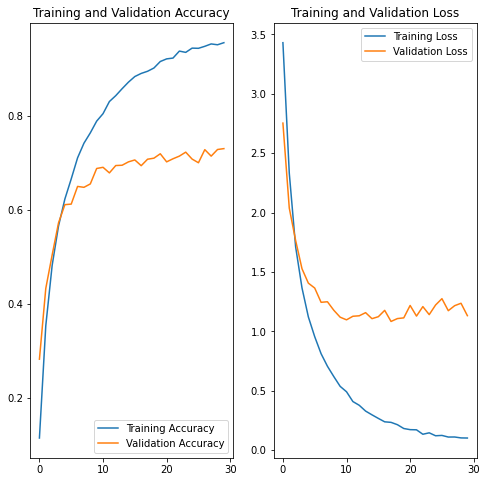

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()